In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Pipeline psuedo code
    n = look back window
    k = number of PCs to keep

    for each time point t:
        p = number of stocks in investable universe at time t
        Define an n x p feature matrix X (lagged returns)

        Perform PCA on X
        Keep the first k PCs in an n x k matrix Z

    for each stock s in the investable universe at time t:
        Define an n x 1 outcome vector y (future returns of stock s)
        Perform a linear regression of y on Z
        Predict y for stock s at time t+1

## Data Preparation

In [3]:
returns = pd.read_pickle("./Data/returns.pkl")
returns = returns.iloc[1:]

In [4]:
drop_columns = []

for col in returns.columns:
    if returns[col].isnull().all() == True:
        drop_columns.append(col)
        
returns.drop(columns=drop_columns, inplace=True)

## Pipeline

In [5]:
def get_investable(t, n):
    """"Find stocks in investable universe at time t+1
    (stocks in the S&P500 that have prices recorded for the last n days)"""
    
    df_investable = returns.copy(deep = True).sort_index(ascending = False)
    
    #add 1 date to get the test features in investable
    t = t + pd.DateOffset(1)
    n += 1
    
    #if t is now a non-trading day, advance until we reach a valid trading day
    while t not in df_investable.index:
        t = t + pd.DateOffset(1)
    
    t_index = df_investable.index.get_loc(t)
    
    #take n_rows worth of data upto time specified
    df_investable = df_investable.iloc[t_index:t_index + n]
    
    #find all stocks that exist in the S&P at this time period
    investable_universe = []
    for col in df_investable.columns:
        if ~df_investable[col].iloc[:n].isna().any():
            investable_universe.append(col)
        
    df_investable = df_investable[investable_universe]
    
    return df_investable

In [6]:
def apply_PCA(inv, k):
    X = inv.iloc[1:, :]
    pca = PCA(n_components = k) 
    inv_scaled = StandardScaler().fit_transform(X)   
    principal_components = pca.fit_transform(inv_scaled)

    df = pd.DataFrame(data = principal_components)
    
    #For explained variance table
    components = pca.components_
    component_explained_var = pca.explained_variance_ratio_ * 100
    
    comp_names = ['PCA' + str(i) for i in range(1, len(component_explained_var) + 1)]

    pca_results = pd.DataFrame(data = component_explained_var, index = comp_names)
    pca_results.columns = ['Explained variance (%)']
    pca_results['Explained variance (%)'] = pca_results['Explained variance (%)'].round(2)
    
    return df

In [7]:
def define_y(inv, stock):
    y = inv[[stock]].iloc[:-1]
    
    return y

In [253]:
def train_test_val(X, y):
    X_train = X.iloc[1:, :]
    X_test = X.iloc[0:1, :]
    
    y_train = y.iloc[1:]
    y_test = y.iloc[0:1]
    
    train_size = int(len(X_train) * 0.8)
    
    X_val = X_train.iloc[train_size:]
    y_val = y_train.iloc[train_size:]
    
    X_train = X_train.iloc[:train_size]
    y_train = y_train.iloc[:train_size]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [237]:
def train_test(X, y):
    X_train = X.iloc[1:, :]
    X_test = X.iloc[0:1, :]
    
    y_train = y.iloc[1:]
    y_test = y.iloc[0:1]

    return X_train, y_train, X_test, y_test

In [256]:
def reshape_val(X_train, y_train, X_val, y_val, X_test, y_test):
    X_train = X_train.values.reshape(-1, X_train.shape[0], X_train.shape[1])
    X_val = X_val.values.reshape(-1, X_val.shape[0], X_val.shape[1])
    X_test = X_test.values.reshape(-1, X_train.shape[0], X_test.shape[1])
    
    y_train = y_train.values.reshape(-1, y_train.shape[0], y_train.shape[1])
    y_val = y_val.values.reshape(-1, y_val.shape[0], y_val.shape[1])
    y_test = y_test.values.reshape(-1, y_test.shape[0], y_test.shape[1])
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [271]:
def reshape(X_train, y_train, X_test, y_test):
    X_train = X_train.values.reshape(-1, X_train.shape[0], X_train.shape[1])
    X_test = X_test.values.reshape(-1, X_train.shape[0], X_test.shape[1])
    
    y_train = y_train.values.reshape(-1, y_train.shape[0], y_train.shape[1])
    y_test = y_test.values.reshape(-1, y_test.shape[0], y_test.shape[1])
    
    return X_train, y_train, X_test, y_test

In [272]:
from keras.optimizers import Adam

def model_fit(X_train, y_train, X_val, y_val):
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]),
                   return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(100))
    model.add(Dropout(0.2))
    model.add(Dense(y_train.shape[0]))
    
    model.compile(loss = 'mse', optimizer = Adam())
    
    early_stopping = EarlyStopping(monitor="val_loss", min_delta=0.001, patience=5)
    
    history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data = (X_val, y_val),
                        verbose = 0)
    
    return model, history

In [273]:
def model_predict(model, X_test):
    yhat = model.predict(X_test, verbose = 0)
    
    return yhat

In [274]:
def test():
    time_range = returns.loc['2010':'2012'].index[:10]
    returns_t = pd.DataFrame(index = time_range, columns = ['Pred', 'Actual'])
    
    n = 201
    k = 20
    
    count = 0
    for t in time_range[:-1]:
        inv = get_investable(t, n)
        X = apply_PCA(inv, k)
        y = define_y(inv, inv.columns[0])
        X_train, y_train, X_val, y_val, X_test, y_test = train_test_val(X, y)
        X_train, y_train, X_val, y_val, X_test, y_test = reshape_val(X_train, y_train, X_val, y_val, X_test, y_test)
        model, history = model_fit(X_train, y_train, X_val, y_val)
        
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')
        plt.show()
        
        yhat = model_predict(model, X_test)[0][0]
        actual = y_test[0][0][0]

        t_index = time_range.get_loc(t) + 1
        
        returns_t['Pred'].iloc[t_index] = yhat
        returns_t['Actual'].iloc[t_index] = actual
        
        
        count += 1
        print(f'{(count/len(time_range))*100:.2f}% complete')
    
    returns_t.dropna(inplace = True)
    returns_t['Pred'] = returns_t['Pred'].astype(float)
    returns_t['Actual'] = returns_t['Actual'].astype(float)


    return returns_t

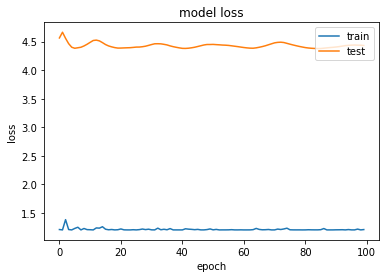

10.00% complete


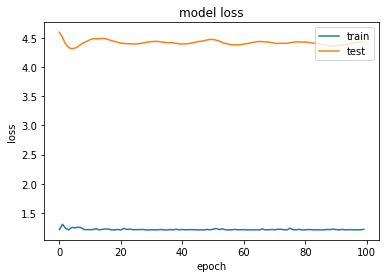

20.00% complete


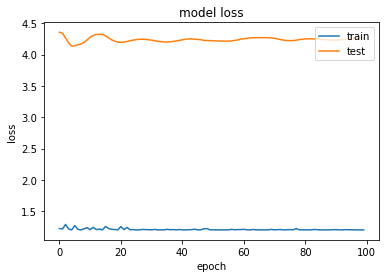

30.00% complete


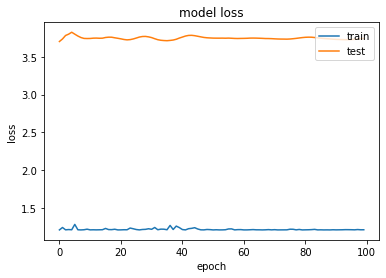

40.00% complete


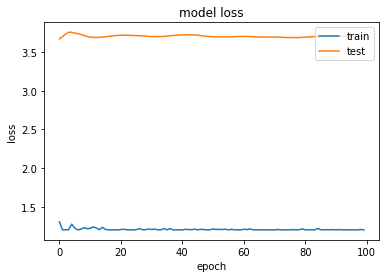

50.00% complete


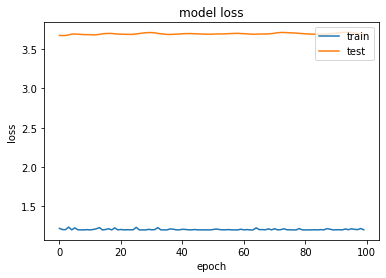

60.00% complete


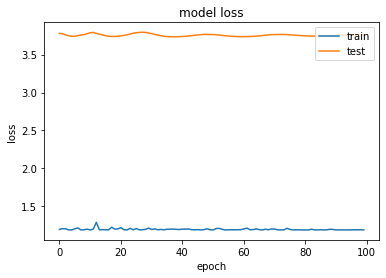

70.00% complete


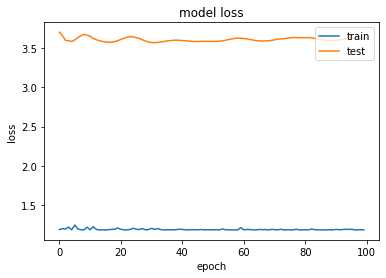

80.00% complete


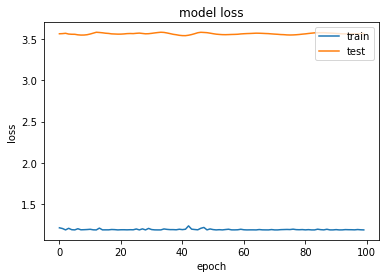

90.00% complete


In [275]:
test = test()

In [230]:
test

,Pred,Actual
date,,
2010-01-05,-0.042133,-0.808206
2010-01-06,-0.022139,0.555575
2010-01-07,0.000742,0.828373
2010-01-08,0.016602,0.511333
2010-01-11,0.015954,0.508352
2010-01-12,0.021658,-0.288964
2010-01-13,0.030542,0.217446
2010-01-14,0.011971,0.108487
2010-01-15,0.026364,0.252988


In [231]:
from sklearn.metrics import r2_score, mean_squared_error
r2 = r2_score(test['Actual'].values, test['Pred'].values)
mse = mean_squared_error(test['Actual'].values, test['Pred'].values)

In [232]:
print(r2)
print(mse)

-0.15426091738680237
0.25387820458841653


In [58]:
def predict_returns(t, n, k, model, refit = True):
    inv = get_investable(t, n)
    X = apply_PCA(inv, k)
    
    returns_t = pd.DataFrame(index = inv.columns, columns = ['Pred', 'Actual'])
    
    for stock in inv.columns:
        y = define_y(inv, stock)
        X_train, y_train, X_test, y_test = train_test(X, y)
        X_train, y_train, X_test, y_test = reshape(X_train, y_train, X_test, y_test)
        
        if refit:
            model = model_fit(X_train, y_train)
            
        yhat = model_predict(model, X_test)[0][0]
        returns_t['Pred'].loc[stock] = yhat
        returns_t['Actual'].loc[stock] = y_test[0][0][0]
    
    return returns_t, model

In [13]:
def rank_stocks(returns, num_stocks):
    pred_returns = returns.sort_values(by = 'Pred', ascending = False)
    topn = pred_returns.head(num_stocks)
    botn = pred_returns.tail(num_stocks)
    
    return topn, botn

In [14]:
def portfolio_return(topn, botn, returns):
    return_t = topn['Actual'].mean() - botn['Actual'].mean()
    
    return return_t

In [15]:
def pipeline(n, k, num_stocks):

    time_range = returns.loc['2015':'2021'].index
    returns_monthly = returns.resample('M').mean()
    
    for i in range(len(time_range)):
        if time_range[i] in returns_monthly.index:
            time_range = time_range[i:]
            break
    
    portfolio = pd.DataFrame(index = time_range, columns = ['Portfolio Return'])
    current_model = Sequential()
    
    count = 0
    for t in time_range[0:2]:
        if t in returns_monthly.index:
            pred_actual, current_model = predict_returns(t, n, k, current_model, refit = True)
        else:
            pred_actual, current_model = predict_returns(t, n, k, current_model, refit = False)
        
        topn, botn = rank_stocks(pred_actual, num_stocks)
        return_t = portfolio_return(topn, botn, pred_actual)
        t_index = time_range.get_loc[t] + 1
        portfolio['Portfolio Return'].loc[time_range[t_index]] = return_t
        
        count +=1
        print(f'{(count/len(time_range))*100:.2f}% complete')
    
    return portfolio

In [16]:
portfolio = pipeline(50, 20, 5)

KeyboardInterrupt: 

In [ ]:
#start at 7:38am
print(pd.datetime.now())